# Cubicasa Dataset Parser

This is the prototype for parsing the cubicasa svg files into images.

## References
https://github.com/CubiCasa/CubiCasa5k

In [16]:
import os
import time
import math
import numpy as np
from numpy import genfromtxt

from xml.dom import minidom

from skimage.draw import polygon
import skimage.measure as skm

from svgpathtools import parse_path

from logging import warning

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pickle

from random import randint

from loaders.house import House, icons_selected, rooms_selected, icon_name_map, room_name_map

from torch.utils.data import Dataset
import pickle
import torch
import lmdb
import cv2

import matplotlib.patches as patches
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from pycocotools import mask as coco_mask

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode

## Variables

In [4]:
CUBICASA_DIR = "./data/Cubicasa/"
DATA_DIR = './data/Cubicasa/compiled/'
PROCESSED_DATA_DIR = './data/detectron_training_data/'
DATA_FILE = 'compiled_train.txt'
# DATA_FILE = 'train.txt'
# DATA_FILE = 'debug.txt'
TEST_DATA_FILE = 'debug_test.txt'
DATA_REF_FILE = "./data/Cubicasa/debug.txt"
CLASSES = ['Wall', 'Window', 'Door']

## Preprocess labels from Cubicasa dataset

In [10]:
room_mapping = {"Background": 0}  # Explicitly set Background to 0
idx = 1  # Start indexing from 1

for i in room_name_map:
    generalised_class = room_name_map[i]
    if generalised_class not in room_mapping:
        room_mapping[generalised_class] = idx
        idx += 1

icon_mapping = {}
for i in icon_name_map:
    generalised_class = icon_name_map[i]
    if generalised_class not in icon_mapping:
        icon_mapping[generalised_class] = idx
        idx += 1

# print(room_mapping)
# print(icons_mapping)

# combined_mapping = {**room_mapping, **icon_mapping}
combined_mapping = {
    "room_mapping":room_mapping,
    "icon_mapping":icon_mapping
}
print(combined_mapping)

{'room_mapping': {'Background': 0, 'Room': 1, 'Bath': 2, 'Bedroom': 3, 'Garage': 4, 'Storage': 5, 'Dining': 6, 'Entry': 7, 'Kitchen': 8, 'LivingRoom': 9, 'Outdoor': 10, 'Wall': 11, 'Railing': 12}, 'icon_mapping': {'Window': 13, 'Door': 14, 'Closet': 15, 'ElectricalAppliance': 16, 'Toilet': 17, 'Sink': 18, 'SaunaBench': 19, 'Fireplace': 20, 'Bathtub': 21, 'Chimney': 22, None: 23, 'None': 24}}


## Detectron2 Training Pipeline

### Try encode mask with pycocotools

In [13]:
def encode_masks_to_rle(sample, class_names, rooms_selected, icons_selected):
    label_tensor = sample['label'].numpy()  # Shape: (channels, H, W)
    height, width = label_tensor.shape[1:]  # Image dimensions
    rle_annotations = []

    for class_name in class_names:
        if class_name in rooms_selected:
            channel = 0  # Rooms are in channel 0
            labeled_mask = rooms_selected[class_name]
        elif class_name in icons_selected:
            channel = 1  # Icons are in channel 1
            labeled_mask = icons_selected[class_name]
        else:
            raise ValueError(f"Class '{class_name}' not found in rooms_selected or icons_selected.")

        # Create a binary mask for the given class
        binary_mask = (label_tensor[channel] == labeled_mask).astype(np.uint8)

        # Encode the binary mask to RLE
        rle = coco_mask.encode(np.asfortranarray(binary_mask))  # Fortran order required by pycocotools
        rle['counts'] = rle['counts'].decode('utf-8')  # Convert counts to string for JSON compatibility

        # Append the encoded mask with additional metadata
        rle_annotations.append({
            "segmentation": rle,
            "category_id": labeled_mask,
            "height": height,
            "width": width,
        })

    return rle_annotations

### Custom Dataset Loader for Detectron2

In [52]:
def visualize_annotation_bitmask(record, classes):
    """
    Visualize bitmask annotations using OpenCV.

    Parameters:
        - record (dict): A single dataset record containing:
            {
                "file_name": str,
                "annotations": [
                    {
                        "bbox": [...],
                        "category_id": int,
                        "segmentation": [[x0, y0, x1, y1, ...], ...] (optional),
                        "rle": {
                            "size": [H, W],
                            "counts": "...",  # RLE byte string
                        } (optional)
                    },
                    ...
                ]
            }
        - classes (list): List of class names corresponding to category indices.
    Returns:
        - None
    """
    # Generate random colors for each class
    class_colors = {class_name: [np.random.randint(0, 255) for _ in range(3)] for class_name in classes}

    # Load the image
    image = cv2.imread(record["file_name"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    # Create an empty overlay for masks
    overlay = np.zeros((height, width, 3), dtype=np.uint8)

    # Process each annotation
    for ann in record["annotations"]:
        category_id = ann["category_id"]
        class_name = classes[category_id] if category_id < len(classes) else f"Class {category_id}"
        color = class_colors[class_name]

        # Handle RLE Masks
        if "rle" in ann:
            rle = ann["rle"]
            mask = coco_mask.decode(rle)  # Decode RLE into binary mask (H, W)
            if len(mask.shape) == 3:
                mask = mask[:, :, 0]  # Remove singleton dimensions

        # Handle Polygon Masks
        elif "segmentation" in ann:
            mask = np.zeros((height, width), dtype=np.uint8)
            for segment in ann["segmentation"]:
                polygon = np.array(segment).reshape((-1, 2))
                cv2.fillPoly(mask, [polygon.astype(np.int32)], 1)  # Fill mask with 1s
        
        else:
            print(f"Warning: Annotation for {class_name} has no valid segmentation or RLE. Skipping.")
            continue

        # Debug: Ensure valid mask
        if np.sum(mask) == 0:
            print(f"Warning: Empty mask detected for {class_name}. Skipping.")
            continue

        # Apply the mask to the overlay
        for c in range(3):
            overlay[:, :, c] = np.where(mask == 1, color[c], overlay[:, :, c])

    # Blend overlay with the original image
    blended = cv2.addWeighted(image, 0.6, overlay, 0.4, 0)

    # Plot Original Image, Masks, and Overlay
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Masks
    axes[1].imshow(overlay)
    axes[1].set_title("Masks")
    for idx, class_name in enumerate(classes):
        color = class_colors[class_name]
        axes[1].text(
            10, 30 + idx * 20,
            f"{class_name}",
            color=np.array(color) / 255.0,
            fontsize=12,
            backgroundcolor="black"
        )
    axes[1].axis("off")

    # Overlay
    axes[2].imshow(blended)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

In [59]:
def get_floorplan_dicts(dataset_dir, class_names, mapping, num_data=500):
    dataset_dicts = []
    images_folder = os.path.join(dataset_dir, "images")
    labels_folder = os.path.join(dataset_dir, "labels")
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith(".png")], key=lambda x: int(x.split('.')[0]))

    # Iterate through the image files
    for idx, image_name in enumerate(image_files):
        if num_data is not None and idx >= num_data:
            break

        img_path = os.path.join(images_folder, image_name)
        base_name = os.path.splitext(image_name)[0]
        label_path = os.path.join(labels_folder, f"{base_name}.npy")

        if not os.path.exists(label_path):
            print(f"Warning: Label file {label_path} not found. Skipping.")
            continue

        # Read the image
        # Note: The images should be already normalized and saved as PNG.
        #       We can directly read them using plt.imread or similar methods.
        image = plt.imread(img_path)
        if image.dtype != np.uint8:
            # If the image was saved differently, ensure it is uint8
            image = (image * 255).astype(np.uint8)

        height, width = image.shape[:2]

        # Read the label
        label_tensor = np.load(label_path)  # Shape: (channels, H, W)
        # In the preprocessed format, label_tensor might already contain final class indices.

        record = {}
        record["file_name"] = img_path
        record["height"] = height
        record["width"] = width
        record["image_id"] = idx

        annotations = []

        # For each class, find instances in the label tensor
        # We know:
        # - Room classes are in channel 0
        # - Icon classes are in channel 1
        # Based on preprocess, rooms_selected and icons_selected now contain final indices.
        normalised_label_val = 0
        for class_name in class_names:

            if class_name in mapping['room_mapping']:
                channel = 0
                label_value = mapping['room_mapping'][class_name]

            elif class_name in mapping['icon_mapping']:
                channel = 1
                label_value = mapping['icon_mapping'][class_name]

            # Create a binary mask for this class
            binary_mask = (label_tensor[channel] == label_value).astype(np.uint8)

            # Find connected components for each instance of this class
            connected_components = skm.label(binary_mask)
            regions = skm.regionprops(connected_components)

            for region in regions:
                # Extract bounding box in (min_row, min_col, max_row, max_col) format
                min_row, min_col, max_row, max_col = region.bbox
                bbox = [min_col, min_row, max_col, max_row]  # Convert to (x_min, y_min, x_max, y_max)

                # Encode the binary mask to RLE
                # For each region, create a mask of that region only
                instance_mask = (connected_components == region.label).astype(np.uint8)

                # 1) Encode to RLE
                rle = coco_mask.encode(np.asfortranarray(instance_mask))
                # If you want standard COCO compressed counts, do NOT decode rle['counts'] into utf-8.

                # Add annotation
                annotations.append({
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    # "category_id": label_value,
                    "category_id": normalised_label_val,
                    "segmentation": rle,
                    "iscrowd": 0,
                })

            normalised_label_val += 1

        record["annotations"] = annotations
        # visualize_annotation_bitmask(record, class_names)
        dataset_dicts.append(record)

    # After processing all samples, save the dataset_dicts to a .pkl file
    pkl_path = os.path.join(dataset_dir, "floorplan_dicts.pkl")
    with open(pkl_path, 'wb') as f:
        pickle.dump(dataset_dicts, f)

    return dataset_dicts

### Save floorplan dicts

In [60]:
# Generate the dataset dicts once
# floorplan_dicts = get_floorplan_dicts(PROCESSED_DATA_DIR, CLASSES, combined_mapping, num_data=1)
floorplan_dicts = get_floorplan_dicts(PROCESSED_DATA_DIR, ['Wall'], combined_mapping, num_data=100)

### Training configuration and setup

In [61]:
# Load the dataset dicts
pkl_path = os.path.join(PROCESSED_DATA_DIR, "floorplan_dicts.pkl")
with open(pkl_path, "rb") as f:
    floorplan_dicts = pickle.load(f)

dataset_name = "floorplan_svg_dataset"
if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)

DatasetCatalog.register(dataset_name, lambda: floorplan_dicts)
MetadataCatalog.get(dataset_name).set(thing_classes=CLASSES)
metadata = MetadataCatalog.get(dataset_name)

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = ()  # No test set
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025
cfg.INPUT.MASK_FORMAT = "bitmask"

# To run x epoch, set iterations = datapoints/batches * x
# cfg.SOLVER.MAX_ITER = 12500 # 100 epochs
cfg.SOLVER.MAX_ITER = 6250 # 50 epochs

# cfg.SOLVER.MAX_ITER = 5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CLASSES)
cfg.MODEL.DEVICE = 'cuda'

### Train

In [62]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/22 10:20:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[12/22 10:20:50 d2.engine.train_loop]: Starting training from iteration 0


/home/biffly/miniconda3/envs/aiml/lib/python3.11/site-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/biffly/miniconda3/envs/aiml/lib/python3.11/site-packages/detectron2/data/detection_utils.py:449: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be

[12/22 10:21:05 d2.utils.events]:  eta: 1:07:41  iter: 19  total_loss: 2.111  loss_cls: 1.161  loss_box_reg: 0.1051  loss_mask: 0.691  loss_rpn_cls: 0.1196  loss_rpn_loc: 0.02836    time: 0.6726  last_time: 0.5489  data_time: 0.1151  last_data_time: 0.0083   lr: 4.9953e-06  max_mem: 10148M
[12/22 10:21:20 d2.utils.events]:  eta: 1:07:28  iter: 39  total_loss: 1.908  loss_cls: 1.012  loss_box_reg: 0.1143  loss_mask: 0.6537  loss_rpn_cls: 0.06695  loss_rpn_loc: 0.03161    time: 0.6940  last_time: 0.6038  data_time: 0.1128  last_data_time: 0.0154   lr: 9.9902e-06  max_mem: 10148M
[12/22 10:21:33 d2.utils.events]:  eta: 1:05:46  iter: 59  total_loss: 1.588  loss_cls: 0.7354  loss_box_reg: 0.1148  loss_mask: 0.583  loss_rpn_cls: 0.08397  loss_rpn_loc: 0.02624    time: 0.6871  last_time: 0.6198  data_time: 0.0780  last_data_time: 0.0143   lr: 1.4985e-05  max_mem: 10148M
[12/22 10:21:47 d2.utils.events]:  eta: 1:06:41  iter: 79  total_loss: 1.221  loss_cls: 0.4744  loss_box_reg: 0.1215  loss_

/home/biffly/miniconda3/envs/aiml/lib/python3.11/site-packages/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[12/22 10:36:54 d2.utils.events]:  eta: 0:53:57  iter: 1359  total_loss: 0.2924  loss_cls: 0.03953  loss_box_reg: 0.05105  loss_mask: 0.1661  loss_rpn_cls: 0.002713  loss_rpn_loc: 0.01727    time: 0.7069  last_time: 0.5851  data_time: 0.0667  last_data_time: 0.0160   lr: 0.00025  max_mem: 10672M
[12/22 10:37:09 d2.utils.events]:  eta: 0:53:43  iter: 1379  total_loss: 0.2684  loss_cls: 0.03828  loss_box_reg: 0.04894  loss_mask: 0.1662  loss_rpn_cls: 0.002641  loss_rpn_loc: 0.01786    time: 0.7072  last_time: 0.6277  data_time: 0.1053  last_data_time: 0.0094   lr: 0.00025  max_mem: 10760M
[12/22 10:37:23 d2.utils.events]:  eta: 0:53:30  iter: 1399  total_loss: 0.2788  loss_cls: 0.03477  loss_box_reg: 0.05298  loss_mask: 0.1649  loss_rpn_cls: 0.002327  loss_rpn_loc: 0.01386    time: 0.7071  last_time: 0.5863  data_time: 0.0943  last_data_time: 0.0108   lr: 0.00025  max_mem: 10760M
[12/22 10:37:37 d2.utils.events]:  eta: 0:53:14  iter: 1419  total_loss: 0.2816  loss_cls: 0.0355  loss_box_r

/home/biffly/miniconda3/envs/aiml/lib/python3.11/site-packages/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[12/22 10:52:59 d2.utils.events]:  eta: 0:39:08  iter: 2699  total_loss: 0.1997  loss_cls: 0.02126  loss_box_reg: 0.0308  loss_mask: 0.1292  loss_rpn_cls: 0.001499  loss_rpn_loc: 0.0129    time: 0.7131  last_time: 0.6324  data_time: 0.0890  last_data_time: 0.0076   lr: 0.00025  max_mem: 10802M
[12/22 10:53:13 d2.utils.events]:  eta: 0:38:50  iter: 2719  total_loss: 0.2035  loss_cls: 0.02227  loss_box_reg: 0.03004  loss_mask: 0.1319  loss_rpn_cls: 0.00144  loss_rpn_loc: 0.01508    time: 0.7131  last_time: 0.9224  data_time: 0.1062  last_data_time: 0.3034   lr: 0.00025  max_mem: 10802M
[12/22 10:53:27 d2.utils.events]:  eta: 0:38:34  iter: 2739  total_loss: 0.1987  loss_cls: 0.02178  loss_box_reg: 0.0328  loss_mask: 0.1317  loss_rpn_cls: 0.001269  loss_rpn_loc: 0.01154    time: 0.7129  last_time: 0.6325  data_time: 0.0777  last_data_time: 0.0125   lr: 0.00025  max_mem: 10802M
[12/22 10:53:42 d2.utils.events]:  eta: 0:38:21  iter: 2759  total_loss: 0.1979  loss_cls: 0.02178  loss_box_reg:

/home/biffly/miniconda3/envs/aiml/lib/python3.11/site-packages/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[12/22 11:05:42 d2.utils.events]:  eta: 0:27:26  iter: 3759  total_loss: 0.183  loss_cls: 0.01873  loss_box_reg: 0.02704  loss_mask: 0.1171  loss_rpn_cls: 0.000625  loss_rpn_loc: 0.01519    time: 0.7145  last_time: 0.8525  data_time: 0.1176  last_data_time: 0.2328   lr: 0.00025  max_mem: 11178M
[12/22 11:05:56 d2.utils.events]:  eta: 0:27:12  iter: 3779  total_loss: 0.1747  loss_cls: 0.02003  loss_box_reg: 0.02746  loss_mask: 0.1153  loss_rpn_cls: 0.0009087  loss_rpn_loc: 0.01172    time: 0.7145  last_time: 0.6511  data_time: 0.1008  last_data_time: 0.0147   lr: 0.00025  max_mem: 11178M
[12/22 11:06:10 d2.utils.events]:  eta: 0:26:58  iter: 3799  total_loss: 0.1762  loss_cls: 0.01965  loss_box_reg: 0.02693  loss_mask: 0.1123  loss_rpn_cls: 0.0005771  loss_rpn_loc: 0.01203    time: 0.7145  last_time: 0.6158  data_time: 0.0886  last_data_time: 0.0093   lr: 0.00025  max_mem: 11178M
[12/22 11:06:24 d2.utils.events]:  eta: 0:26:44  iter: 3819  total_loss: 0.1704  loss_cls: 0.01941  loss_box

### Test

In [63]:
def test_inference(cfg, images, classes, output_dir="./inference"):
    """
    Runs inference on the given set of image file paths, saves the output visualizations, 
    and optionally displays them.

    Parameters:
    - cfg (CfgNode): The configuration for the Detectron2 model.
    - images (list[str]): List of paths to images to run inference on.
    - classes (dict): A dictionary of class names to their corresponding properties 
                      (e.g. {"Wall": {"Type": "mask"}, "Window": {"Type":"bounding_box"}, ...}).
      The index of each class in this dictionary (when extracted as a list) corresponds to the label value.
    - output_dir (str): Directory where the inference results will be saved.

    Returns:
    - None
    """

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the trained model weights
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

    # Initialize the predictor
    predictor = DefaultPredictor(cfg)

    # Get a list of class names in the order they are indexed
    # Ensure that the order in which you define `inference_classes` matches the label indices.
    class_names = list(classes.keys())

    # Loop through each image path and run inference
    for i, img_path in enumerate(images):
        # Read the image from disk (BGR format as OpenCV uses)
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        print(f"Processing image: {img_path}, shape: {image.shape}")

        # Run inference
        outputs = predictor(image)
        instances = outputs["instances"].to("cpu")

        # Create a Visualizer object
        metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]) if len(cfg.DATASETS.TRAIN) > 0 else None
        visualizer = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)

        pred_class_ids = instances.pred_classes if instances.has("pred_classes") else []
        boxes = instances.pred_boxes.tensor if instances.has("pred_boxes") else None
        masks = instances.pred_masks if instances.has("pred_masks") else None

        if boxes is not None:
            for idx, (box, cls_id) in enumerate(zip(boxes, pred_class_ids)):
                box = box.numpy()
                cls_id = int(cls_id)

                # Retrieve the class name from the class_names list using the predicted class ID
                if cls_id < len(class_names):
                    class_name = class_names[cls_id]
                else:
                    class_name = None

                if class_name is None:
                    continue

                class_type = classes[class_name]["Type"]

                # Draw based on the class type
                if class_type == "bounding_box":
                    # Draw bounding box and class name
                    visualizer.draw_box(box)
                    visualizer.draw_text(class_name, tuple(box[:2]))

                elif class_type == "mask":
                    # Draw mask and class name
                    # Ensure masks are available
                    if masks is not None and idx < masks.shape[0]:
                        mask = masks[idx].numpy()
                        # Draw the mask
                        # You can specify a color if desired, but by default it should generate unique colors
                        visualizer.draw_binary_mask(mask, color=None, edge_color=None, alpha=0.5)
                        # Optionally, draw a box or text on the mask
                        # Here we draw the class name at the top-left corner of the bounding box for consistency
                        visualizer.draw_text(class_name, tuple(box[:2]))

        # Get the visualization result
        visualize = visualizer.get_output()
        vis_img = visualize.get_image()[:, :, ::-1]  # Convert back to BGR for consistent handling

        # Determine the folder name from the image path for display and file naming
        folder_name = os.path.basename(os.path.dirname(img_path))
        if folder_name == '':
            folder_name = 'root'

        # Display the results using matplotlib
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {folder_name} - Predicted Classes")
        plt.axis("off")
        plt.show()

        # If desired, uncomment to save the output visualization
        # out_filename = os.path.join(output_dir, f"{folder_name}_inference_{i}.jpg")
        # cv2.imwrite(out_filename, vis_img)
        # print(f"Saved inference result: {out_filename}")


In [64]:
def get_inference_images(data_dir=os.path.join(PROCESSED_DATA_DIR, "images"), num_images=1):
    """
    Returns a list of image file paths for inference.

    Parameters:
    - data_dir (str): Directory containing the images.
    - num_images (int): Number of images to return.

    Returns:
    - list[str]: List of image file paths.
    """
    print (f"Loading {num_images} images from {data_dir}")
    return [os.path.join(data_dir, f"{i}.png") for i in range(num_images)]

Loading 1 images from ./data/detectron_training_data/images
[12/22 11:43:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Processing image: ./data/detectron_training_data/images/0.png, shape: (1063, 1300, 3)


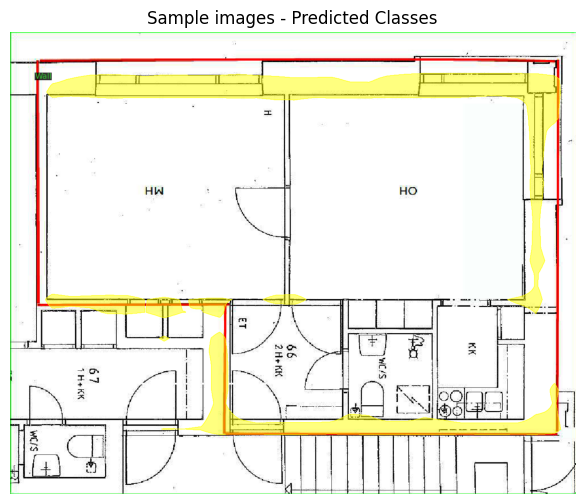

In [65]:
# test_inference(cfg, get_inference_images(), classes=CLASSES)

# Type is either "mask" or "bounding_box". None if you included it in training but dont want to show it.
inference_classes = {
    "Wall": {
        "Type":"mask"
        # "Type":None
    },
    "Window": {
        # "Type":"bounding_box"
        "Type":None
    },
    "Door": {
        # "Type":"bounding_box"
        "Type":None
    }
}
test_inference(cfg, get_inference_images(), classes=inference_classes)

## Visualisation

In [133]:
import numpy as np
import matplotlib.pyplot as plt

def plot_segmentation(sample, class_names, rooms_selected, icons_selected):
    """
    Plots the original image, segmentation masks for specified classes, and an overlay of the masks on the image.

    Parameters:
    - sample (dict): A sample from the FloorplanSVG dataset containing 'image' and 'label'.
    - class_names (list of str): List of class names to visualize (e.g., ["Wall", "Window", "Door"]).
    - rooms_selected (dict): Dictionary mapping room class names to labels.
    - icons_selected (dict): Dictionary mapping icon class names to labels.

    Returns:
    - None
    """
    # Extract image and label from the sample
    image = sample['image'].numpy()  # Shape: (C, H, W)
    label_tensor = sample['label'].numpy()  # Shape: (channels, H, W)

    # Convert image from (C, H, W) to (H, W, C) and normalize to [0, 1]
    image = np.transpose(image, (1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())

    # Initialize a dictionary to hold masks for each class
    masks = {}

    # Generate random colors for each class
    class_colors = {class_name: np.random.rand(3) for class_name in class_names}

    # Iterate over each class name to create masks
    for class_name in class_names:
        if class_name in rooms_selected:
            channel = 0  # Rooms are in channel 0
            label = rooms_selected[class_name]
        elif class_name in icons_selected:
            channel = 1  # Icons are in channel 1
            label = icons_selected[class_name]
        else:
            raise ValueError(f"Class '{class_name}' not found in rooms_selected or icons_selected.")

        # Create a binary mask where the label matches
        mask = (label_tensor[channel] == label).astype(np.uint8)
        masks[class_name] = mask

    # Create a combined mask for overlay
    combined_mask = np.zeros_like(image, dtype=np.float32)

    for class_name, mask in masks.items():
        color = class_colors[class_name]  # Get the random color for the class
        # Apply color to the mask and add to the combined_mask
        for c in range(3):
            combined_mask[:, :, c] += mask * color[c]

    # Ensure the combined mask is within [0, 1]
    combined_mask = np.clip(combined_mask, 0, 1)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Original Image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # 2. Segmentation Masks
    # Stack masks to create a multi-class mask
    stacked_masks = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
    for class_name, mask in masks.items():
        color = class_colors[class_name]
        for c in range(3):
            stacked_masks[:, :, c] += mask * color[c]

    stacked_masks = np.clip(stacked_masks, 0, 1)
    axes[1].imshow(stacked_masks)
    axes[1].set_title('Segmentation Masks')
    axes[1].axis('off')

    # 3. Overlay
    overlay = image.copy()
    overlay = np.clip((overlay * 0.5) + (combined_mask * 0.5), 0, 1)
    axes[2].imshow(overlay)
    axes[2].set_title('Overlay (50% Opacity)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


### Viz test

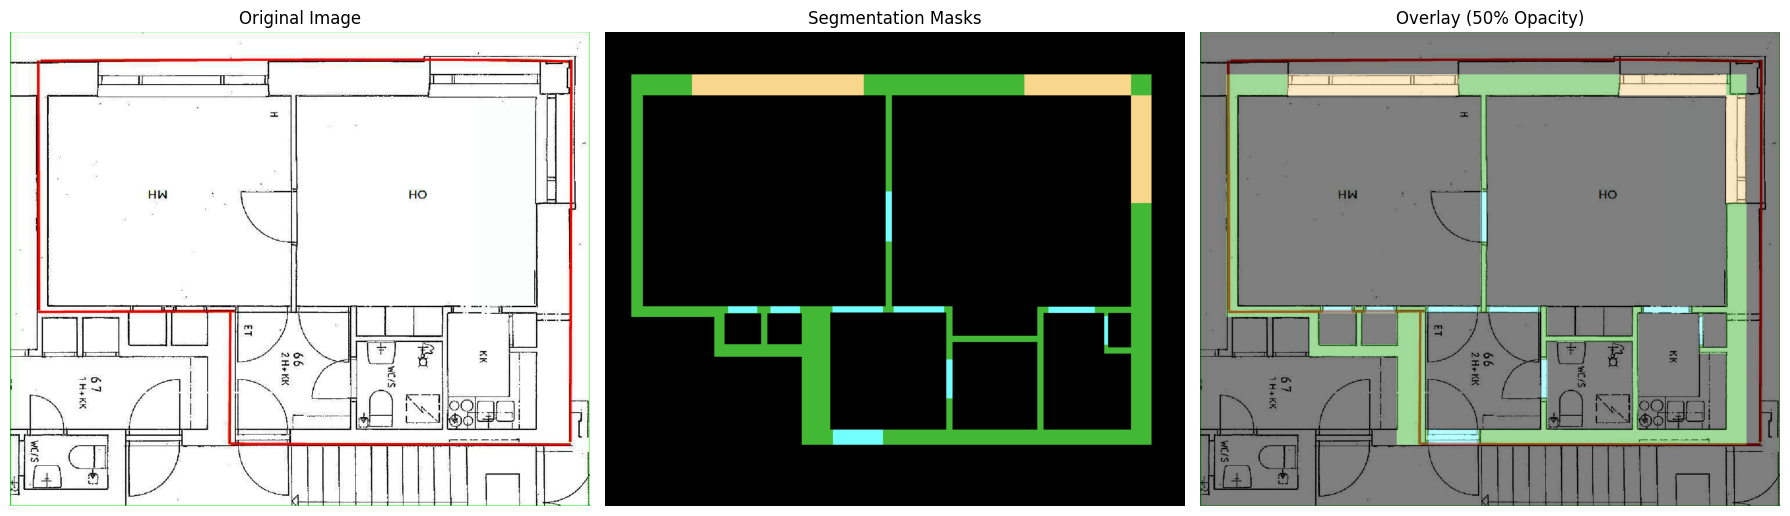

In [221]:
# # Retrieve random sample from the dataset
# sample_index = randint(0, len(dataset) - 1)  # Change this index to view different samples
# sample = dataset[sample_index]

# # Plot the segmentation
# plot_segmentation(sample, CLASSES, rooms_selected, icons_selected)

plot_segmentation(dataset[0], CLASSES, rooms_selected, icons_selected)